# Practical Session on Graph Neural Networks

**by Matthieu Nastorg**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/ 
#####################################################
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [3]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [4]:
### LOAD DATASETS

BATCH_SIZE = 2 

# Train Dataset
train_dataset = PPI(root="", split='train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [7]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x


Next we construct the function to train the model.

In [8]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [9]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [10]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(  input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.6379
F1-Score: 0.4502
Epoch 00002 | Loss: 0.5815
Epoch 00003 | Loss: 0.5623
Epoch 00004 | Loss: 0.5562
Epoch 00005 | Loss: 0.5512
Epoch 00006 | Loss: 0.5456
F1-Score: 0.4850
Epoch 00007 | Loss: 0.5411
Epoch 00008 | Loss: 0.5371
Epoch 00009 | Loss: 0.5340
Epoch 00010 | Loss: 0.5314
Epoch 00011 | Loss: 0.5288
F1-Score: 0.5288
Epoch 00012 | Loss: 0.5264
Epoch 00013 | Loss: 0.5240
Epoch 00014 | Loss: 0.5216
Epoch 00015 | Loss: 0.5193
Epoch 00016 | Loss: 0.5170
F1-Score: 0.5090
Epoch 00017 | Loss: 0.5145
Epoch 00018 | Loss: 0.5120
Epoch 00019 | Loss: 0.5097
Epoch 00020 | Loss: 0.5077
Epoch 00021 | Loss: 0.5057
F1-Score: 0.5325
Epoch 00022 | Loss: 0.5036
Epoch 00023 | Loss: 0.5017
Epoch 00024 | Loss: 0.4996
Epoch 00025 | Loss: 0.4977
Epoch 00026 | Loss: 0.4957
F1-Score: 0.5420
Epoch 00027 | Loss: 0.4937
Epoch 00028 | Loss: 0.4918
Epoch 00029 | Loss: 0.4900
Epoch 00030 | Loss: 0.4882
Epoch 00031 | Loss: 0.4865
F1-Score: 0.5524
Epoch 00032 | Loss: 0.4850
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6560


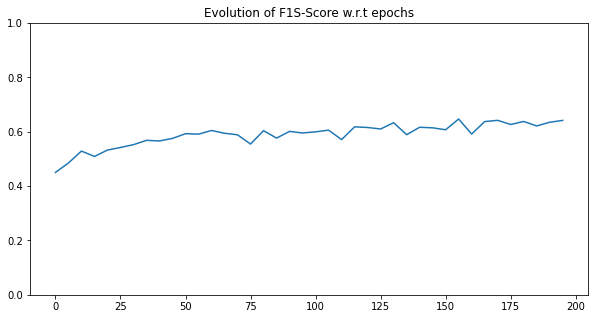

In [11]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))

### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores) :
    plt.figure(figsize=[10,5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [42]:
from torch_geometric.nn import GATv2Conv
class StudentModel(nn.Module):



    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graph1 = GATv2Conv(input_size, hidden_size)
        self.graph2 = GATv2Conv(hidden_size, hidden_size)
        self.graph3 = GATv2Conv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graph1(x, edge_index)
        x = self.elu(x)
        x = self.graph2(x, edge_index)
        x = self.elu(x)
        x = self.graph3(x, edge_index)

        return x

Let's train your model !

In [43]:

## Student model
student_model = StudentModel(input_size = n_features, hidden_size = 256, output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.01)
loss_fcn = nn.CrossEntropyLoss()
### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 176.2522
F1-Score: 0.5171
Epoch 00002 | Loss: 174.7864
Epoch 00003 | Loss: 174.6139
Epoch 00004 | Loss: 173.7602
Epoch 00005 | Loss: 173.6008
Epoch 00006 | Loss: 173.2662
F1-Score: 0.5532
Epoch 00007 | Loss: 172.6562
Epoch 00008 | Loss: 172.0548
Epoch 00009 | Loss: 171.6959
Epoch 00010 | Loss: 171.3791
Epoch 00011 | Loss: 171.0317
F1-Score: 0.5819
Epoch 00012 | Loss: 170.8289
Epoch 00013 | Loss: 170.6082
Epoch 00014 | Loss: 170.3119
Epoch 00015 | Loss: 170.7415
Epoch 00016 | Loss: 170.5480
F1-Score: 0.5958
Epoch 00017 | Loss: 169.8183
Epoch 00018 | Loss: 169.3654
Epoch 00019 | Loss: 169.3975
Epoch 00020 | Loss: 169.0724
Epoch 00021 | Loss: 168.9325
F1-Score: 0.6102
Epoch 00022 | Loss: 168.8029
Epoch 00023 | Loss: 168.8460
Epoch 00024 | Loss: 168.4998
Epoch 00025 | Loss: 168.4011
Epoch 00026 | Loss: 168.4097
F1-Score: 0.6111
Epoch 00027 | Loss: 168.1607
Epoch 00028 | Loss: 167.7862
Epoch 00029 | Loss: 169.4274
Epoch 00030 | Loss: 168.9872
Epoch 00031 | Loss: 168.0278

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.8243


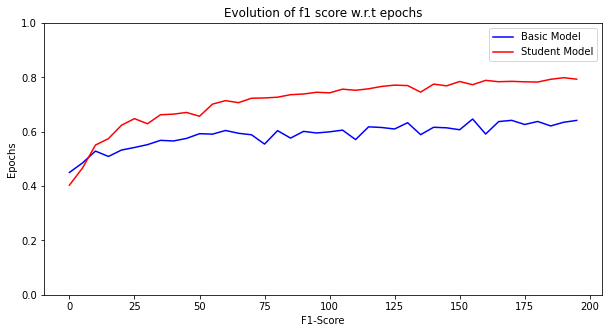

In [36]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

def plot_f1_score(epoch_list, basic_model_scores, student_model_scores) :
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, basic_model_scores, 'b', label = "Basic Model")
    plt.plot(epoch_list, student_model_scores, 'r', label = "Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

(ANSWER)

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. **What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ?** <p>
Oversmoothing in Graph Neural Networks (GNNs) refers to the phenomenon where the node representations become too similar after several layers of message passing, leading to a loss of discriminative power and hindering the GNN's ability to distinguish between nodes with different characteristics. This issue arises due to the aggregation process in each GNN layer, which can lead to an averaging effect. Oversmoothing is a particular concern in semi-supervised learning settings and can limit the GNN's ability to learn a meaningful classifier. Several techniques have been proposed to address this issue, including skip connections, residual connections, and adaptive normalization techniques, to preserve the discriminative power of node representations over multiple layers of message passing.

2. **Are there solutions to overcome it ?** <p>
Yes, there are several techniques that have been proposed to address the issue of oversmoothing in Graph Neural Networks (GNNs). One approach is to use skip connections or residual connections, similar to those used in convolutional neural networks (CNNs), to allow information to bypass some of the layers and preserve the original input information. Another approach is to use adaptive normalization techniques, such as layer normalization or batch normalization, to ensure that the node representations remain diverse across multiple layers of message passing. Additionally, some recent research has focused on developing new architectures for GNNs, such as graph attention networks or graph convolutional networks with attention mechanisms, that can selectively attend to different parts of the graph and avoid oversmoothing. These techniques have shown promise in improving the performance of GNNs on tasks that require the ability to distinguish between nodes with different characteristics.

3. **Do you think the model you constructed is robust with respect to oversmoothing ? Why ?** <p>
The model we constructed, which is a simple Graph Convolutional Network (GCN) with two layers of graph convolutions, may be susceptible to oversmoothing if used on large graphs or if the number of layers is increased. However, it is not possible to definitively say whether the model is robust to oversmoothing without evaluating its performance on a specific task and dataset. To make the GCN more robust to oversmoothing, we can incorporate some of the techniques that have been proposed to address this issue, such as skip connections, residual connections, or adaptive normalization techniques. Additionally, we can experiment with different numbers of layers, learning rates, and other hyperparameters to optimize the performance of the GCN on the task at hand. Ultimately, the robustness of a GNN model with respect to oversmoothing will depend on many factors, including the size and complexity of the graph, the amount of labeled data available, and the specific task being addressed. Therefore, it is important to carefully evaluate the performance of any GNN model on the target task and dataset, and to experiment with different architectures and hyperparameters to optimize its performance. <p>